In [16]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import math
from torch.autograd import Variable
import random
from tqdm import tqdm
import torch.nn.functional as F

In [2]:
class MultiHeadedAttention(nn.Module):
    
    def __init__(self, dims:int, heads:int, block_size:int, dropout:float=0.1):
        
        super(MultiHeadedAttention, self).__init__()
        
        # number of dims must be evenly divisible by num heads
        assert dims % heads == 0
        
        self.dims = dims
        self.heads = heads
        self.block_size = block_size
        self.head_dims = dims // heads
        self.dk_sqrt = math.sqrt(self.head_dims)
        
        self.register_buffer('mask', torch.tril(torch.ones(self.block_size, self.block_size)) \
                             .view(1,1,self.block_size, self.block_size))
        
        self.qkv_projection = nn.Linear(self.dims,self.dims * 3)
        self.attn_dropout = nn.Dropout(dropout)
        self.out_projection = nn.Linear(self.dims,self.dims)
        self.resid_dropout = nn.Dropout(dropout)
        
    def calculate_attention(self, q, k, v, T):
        
        # get similarity of key and query via dot product
        qk_similarity = q @ k.transpose(-2, -1)
        # normalize values by head dims
        normalized_qk_similarity = qk_similarity / self.dk_sqrt
        attention = normalized_qk_similarity.masked_fill(self.mask[:,:,:T,:T] == 0, float('-inf'))
        attention = torch.softmax(normalized_qk_similarity, dim=-1)
        attention = self.attn_dropout(attention)
        out = attention @ v
        
        return out, attention
    
    def forward(self, x):
        
        B, T, C = x.shape # batch size, num tokens, token embedding size
        
        # linear projection for q, k, v
        qkv = self.qkv_projection(x).split(self.dims, dim=2)
        
        # reshape to (batch, heads, tokens, head_dims)
        q, k, v = [cv.view((B, -1, self.heads, self.head_dims)).transpose(1, 2) for cv in qkv]
        
        # calculatue and apply attention
        y, attention = self.calculate_attention(q, k, v, T)
        
        # concat all heads
        y = y.transpose(1, 2).contiguous().view(B, T, C)
        
        # outward projection and residual dropout
        y = self.resid_dropout(self.out_projection(y))
        
        return y

In [3]:
model = MultiHeadedAttention(100, 20, 100)
x = torch.randn(3, 12, 100)
model(model(x)).shape

torch.Size([3, 12, 100])

In [4]:
class PositionalEncoder(nn.Module):
    
    def __init__(self, embedding_dims:int, block_size:int):
        
        super(PositionalEncoder, self).__init__()
        
        self.embedding_dims = embedding_dims
        self.block_size = block_size
        
        positional_embedding = torch.zeros(block_size, embedding_dims)
        div_pos = torch.arange(0, self.embedding_dims, 2)
        divisors = torch.exp(div_pos * -(math.log(10000.0) / self.embedding_dims))
        positions = torch.arange(block_size)[:,None,...]
        
        positional_embedding[:, 0::2] = torch.sin(positions * divisors)
        positional_embedding[:, 1::2] = torch.cos(positions * divisors)
        positional_embedding = positional_embedding[None,...]
        
        self.register_buffer('positional_embedding', positional_embedding)
        
        
        
    def forward(self, x):
        out = Variable(x + self.positional_embedding[:, :x.shape[1]], requires_grad=False)
        return out

In [5]:
class PositionWiseFFN(nn.Module):
    
    def __init__(self, in_dims:int, hidden_dims:int, dropout:float=0.1):
        
        super(PositionWiseFFN, self).__init__()
        
        self.sequence = nn.Sequential(
            nn.Linear(in_dims, hidden_dims),
            nn.ReLU(),
            nn.Linear(hidden_dims, in_dims),
            nn.Dropout(dropout)
        )
        
    def forward(self, x):
        return self.sequence(x)
    
pwffn = PositionWiseFFN(10, 100)
pwffn(torch.randn(5,10,10)).shape

torch.Size([5, 10, 10])

In [6]:
class TransformerBlock(nn.Module):
    
    def __init__(self, 
                 att_heads:int = 8, 
                 att_dims:int = 64,
                 block_size:int = 64
                ):
        
        super(TransformerBlock, self).__init__()
        
        self.att_heads = att_heads
        self.att_dims = att_dims
        self.block_size = block_size
        
        self.ln_1 = nn.LayerNorm(self.att_dims)
        self.attention = MultiHeadedAttention(self.att_dims, self.att_heads, self.block_size)
        self.ln_2 = nn.LayerNorm(self.att_dims)
        self.feed_forward = PositionWiseFFN(self.att_dims, 4 * self.att_dims)
        
    def forward(self, x):
        
        x = x + self.attention(self.ln_1(x))
        x = x + self.feed_forward(self.ln_2(x))
        
        return x
        
tb = TransformerBlock()
x = torch.randn((3,12,64))
tb(x).shape

torch.Size([3, 12, 64])

In [7]:
class DecoderTransformer(nn.Module):
    
    def __init__(self, 
                 vocab_size:int = 32,
                 block_size:int = 64,
                 embedding_dims:int = 64,
                 att_heads:int = 8,
                 layers:int = 3,
                 dropout:float = 0.1
                ):
        
        super(DecoderTransformer, self).__init__()
        
        self.vocab_size = vocab_size
        self.block_size = block_size
        self.embedding_dims = embedding_dims
        self.att_heads = att_heads
        
        self.sequence = nn.Sequential(
            nn.Embedding(self.vocab_size, self.embedding_dims),
            PositionalEncoder(self.embedding_dims, self.block_size), # maybe just change this to an embedding too
            nn.Dropout(dropout),
            nn.Sequential(*[TransformerBlock(self.att_heads, self.embedding_dims, self.block_size) for _ in range(layers)]),
            nn.LayerNorm(self.embedding_dims)
        )
        
        self.lm_head = nn.Linear(self.embedding_dims, self.vocab_size)
        
    def forward(self, x):
        x = self.sequence(x)
        return self.lm_head(x)

model = DecoderTransformer()
x = torch.randint(31, (4,64))
model(x).shape

torch.Size([4, 64, 32])

In [8]:
words = open('./names.txt').read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [9]:
chars = sorted(list(set(''.join(words)))) #lol
token_lookup = {c: i+1 for i, c in enumerate(chars)}
token_lookup['.'] = 0
char_lookup = {i:c for c, i in token_lookup.items()}
TOTAL_TOKENS = len(char_lookup.keys())

In [10]:
# build the dataset

BLOCK_SIZE = 8 # context size to give the model in order to predict the next character

def build_dataset(corpus, block_size, codebook, padding_char="."):
    X, Y = [], []
    for word in corpus:
        start_padding = padding_char * block_size
        padded_word = f"{start_padding}{word}."
        tokenized_word = [codebook[c] for c in padded_word]
        for i in range(len(tokenized_word)-block_size):
            X.append(tokenized_word[i:i+block_size])
            Y.append(tokenized_word[i+block_size])
        
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    
    print(X.shape, Y.shape)
    
    return X, Y


random.shuffle(words)

n1 = int(len(words)*0.8)
n2 = int(len(words)*0.9)

x_train, y_train = build_dataset(words[:n1], BLOCK_SIZE, token_lookup)
x_valid, y_valid = build_dataset(words[n1:n2], BLOCK_SIZE, token_lookup)
x_test, y_test = build_dataset(words[n2:], BLOCK_SIZE, token_lookup)

torch.Size([182413, 8]) torch.Size([182413])
torch.Size([22947, 8]) torch.Size([22947])
torch.Size([22786, 8]) torch.Size([22786])


In [46]:
model = DecoderTransformer()
print(sum(p.numel() for p in model.parameters()))

device = 'cuda:1'
steps = 10000
print_steps = 2000
BATCH_SIZE = 256

losses = []

optim = torch.optim.Adam(model.parameters())
pbar = tqdm(range(steps))

model.to(device)

for t in pbar:
    batch_ix = torch.randint(0, x_train.shape[0], (BATCH_SIZE,))
    batch = x_train[batch_ix].to(device)
    logits = model(batch).mean(1)
    
    #plucked_logits = logits[:,0::BLOCK_SIZE].view(-1, logits.shape[-1])
    loss = F.cross_entropy(logits, y_train[batch_ix].to(device))
    losses.append(loss.item())
    pbar.set_description(desc=f'average loss: {(sum(losses[-100:])/100):.2f}')

    model.zero_grad()
    loss.backward()
    optim.step()

154208


average loss: 2.01: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:21<00:00, 122.86it/s]


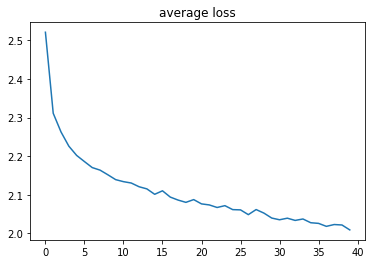

In [47]:
plt.plot(torch.tensor(losses).view(-1, 250).mean(1))
plt.title("average loss");

In [49]:
model.to('cpu')
model.train(False)

# clculate training and validation loss
@torch.no_grad()
def calc_loss(x_target, y_target):
    logits = model(x_target).mean(1)
    #plucked_logits = logits[:,0::BLOCK_SIZE].view(-1, logits.shape[-1])
    loss = F.cross_entropy(logits, y_target)
    return loss

('train', calc_loss(x_train, y_train).item()), ('val', calc_loss(x_valid, y_valid).item())

(('train', 1.9699320793151855), ('val', 2.016996383666992))

In [50]:
# sample
@torch.no_grad()
def sample():
    tokens = [0] * BLOCK_SIZE
    while True:
        cur_tokens = torch.tensor(tokens[-BLOCK_SIZE:]).unsqueeze(0)
        logits = model(cur_tokens).squeeze()
        probs = F.softmax(logits.mean(0), dim=0)
        ix = torch.multinomial(probs, num_samples=1).item()
        tokens.append(ix)
        if ix == 0:
            break
    return "".join([char_lookup[t] for t in tokens][BLOCK_SIZE:-1])

for i in range(20):
    print(sample())

kandron
tai
dorader
jazleeigh
samila
rosett
illiana
phile
gebioli
petram
maven
kolson
quinstafud
khilder
daydynn
samarius
ella
anurmana
liley
aave
